In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)

xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

xs = xs.drop(columns=["id", "mort_28", "peep_regime"])
columns_x = xs.columns

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1

norm_xs = (xs - xs.mean())/xs.std()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,urea,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.334012,0.705302,-0.416477,-0.675390,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.385550,-0.768253,-1.823462,-1.141620,1.996152,...,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.090864,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.403630,1.164175,1.468983,-0.468897,...,0.703662,-0.434729,0.188444,-1.071592,-0.035368,-0.810207,0.317210,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.403630,1.901629,1.395651,-0.811559,...,1.738181,-1.503965,0.964519,-1.046993,-0.868889,-0.810207,0.640620,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-0.680401,-1.236080,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.478767,0.541000,-0.005574,0.373186,-0.428608,-0.265020,0.252528,-0.955742,-0.205677,-0.683525
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-0.810207,-1.028174,-0.927655,-0.301502,0.140252
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.554080,0.137359,-0.648735,0.281012,-0.869185,...,0.532742,1.377339,-0.626434,1.846693,-0.299739,2.733506,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.444100,...,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.451799,0.113924,0.199255,2.694801,1.737565


In [3]:
full_data = imp_xs.assign(W=w, Y=y)

In [4]:
train, test = train_test_split(full_data, test_size=0.3)
train_x = train[columns_x]
test_x = test[columns_x]

# Estimate treatment based on features

PermutationExplainer explainer: 3942it [01:13, 48.70it/s]                          


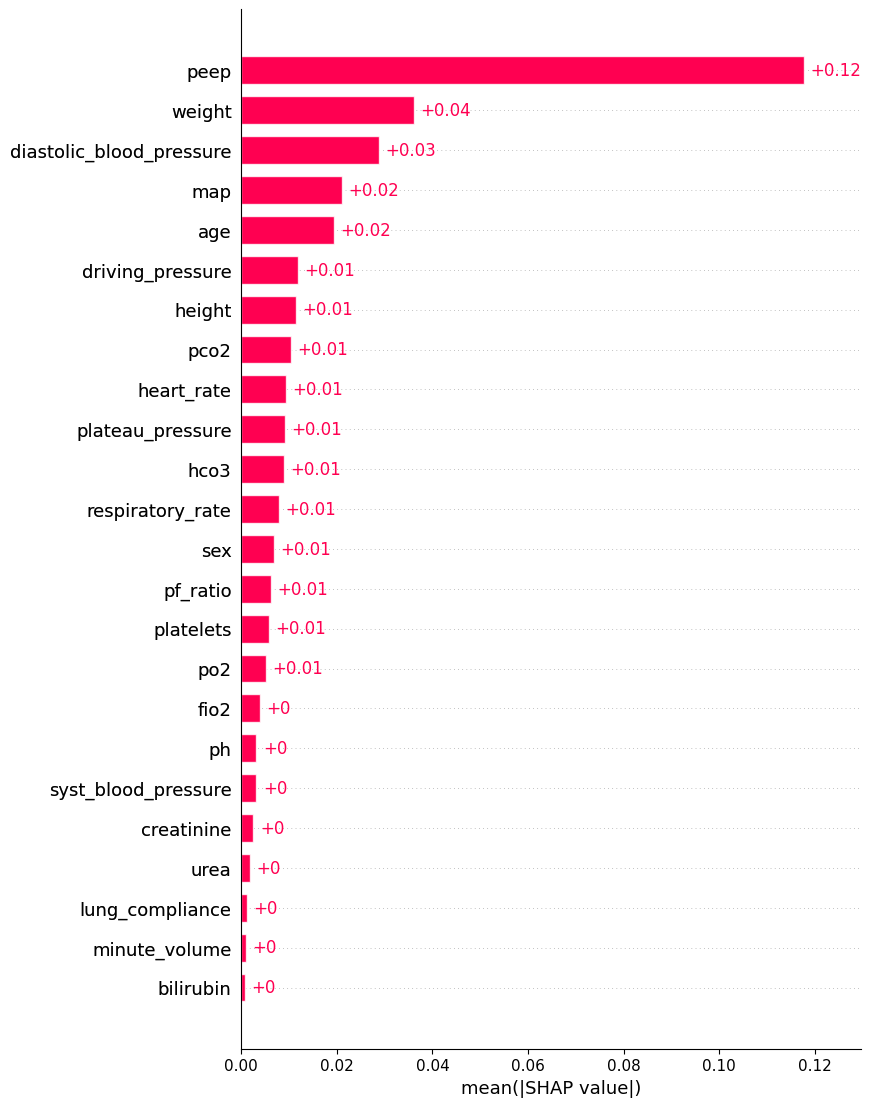

In [5]:
lin_reg_treat = LinearRegression()
lin_reg_treat.fit(full_data[columns_x], full_data["W"])

# mse_train = mean_squared_error(train["W"], lin_reg.predict(train_x))
# mse_test = mean_squared_error(test["W"], lin_reg.predict(test_x))

explainer_lin_reg_treat = shap.Explainer(lin_reg_treat.predict, shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_treat = explainer_lin_reg_treat(imp_xs)
shap.plots.bar(shap_values_treat, max_display=24)

# Estimate outcome based on features

PermutationExplainer explainer: 3942it [01:09, 48.60it/s]                          


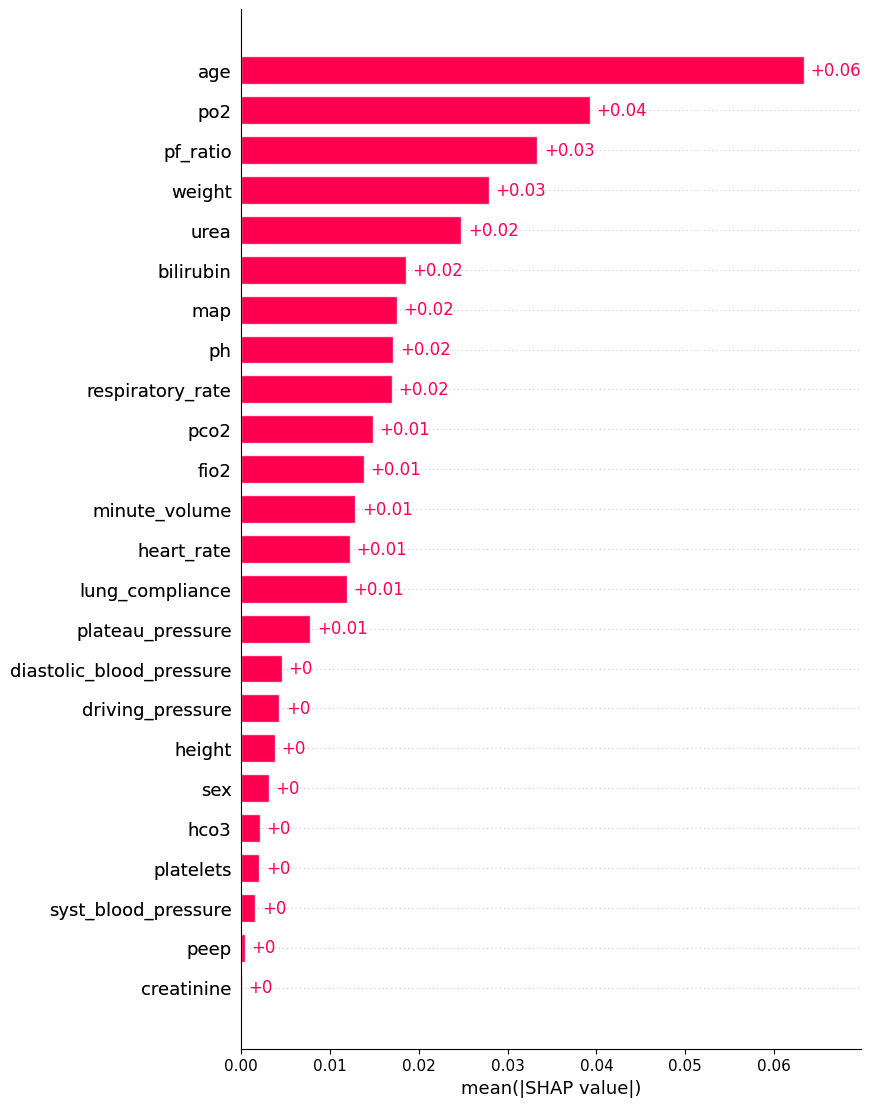

In [6]:
lin_reg_out = LinearRegression()
lin_reg_out.fit(full_data[columns_x], full_data["Y"])

# mse_train = mean_squared_error(train["W"], lin_reg.predict(train_x))
# mse_test = mean_squared_error(test["W"], lin_reg.predict(test_x))

explainer_lin_reg_out = shap.Explainer(lin_reg_out.predict, shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_out = explainer_lin_reg_out(imp_xs)
shap.plots.bar(shap_values_out, max_display=24)

In [3]:
imp_xs = imp_xs.drop(columns=["peep"])
full_data = imp_xs.assign(W=w, Y=y)
full_data
columns_x = imp_xs.columns

PermutationExplainer explainer: 3942it [01:24, 41.64it/s]                          


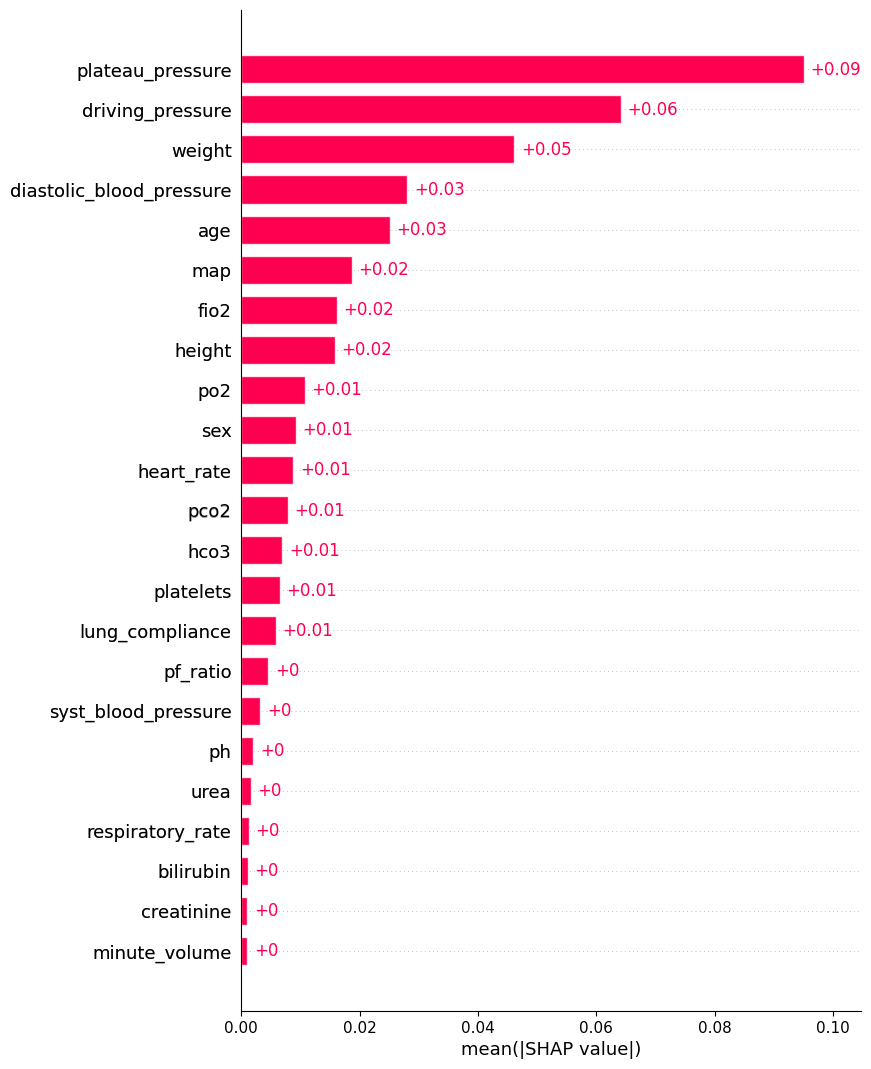

In [12]:
lin_reg_treat = LinearRegression()
lin_reg_treat.fit(full_data[columns_x], full_data["W"])

explainer_lin_reg_treat = shap.Explainer(lin_reg_treat.predict, shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_treat = explainer_lin_reg_treat(imp_xs)
shap.plots.bar(shap_values_treat, max_display=24)

PermutationExplainer explainer: 3942it [01:15, 46.97it/s]                          


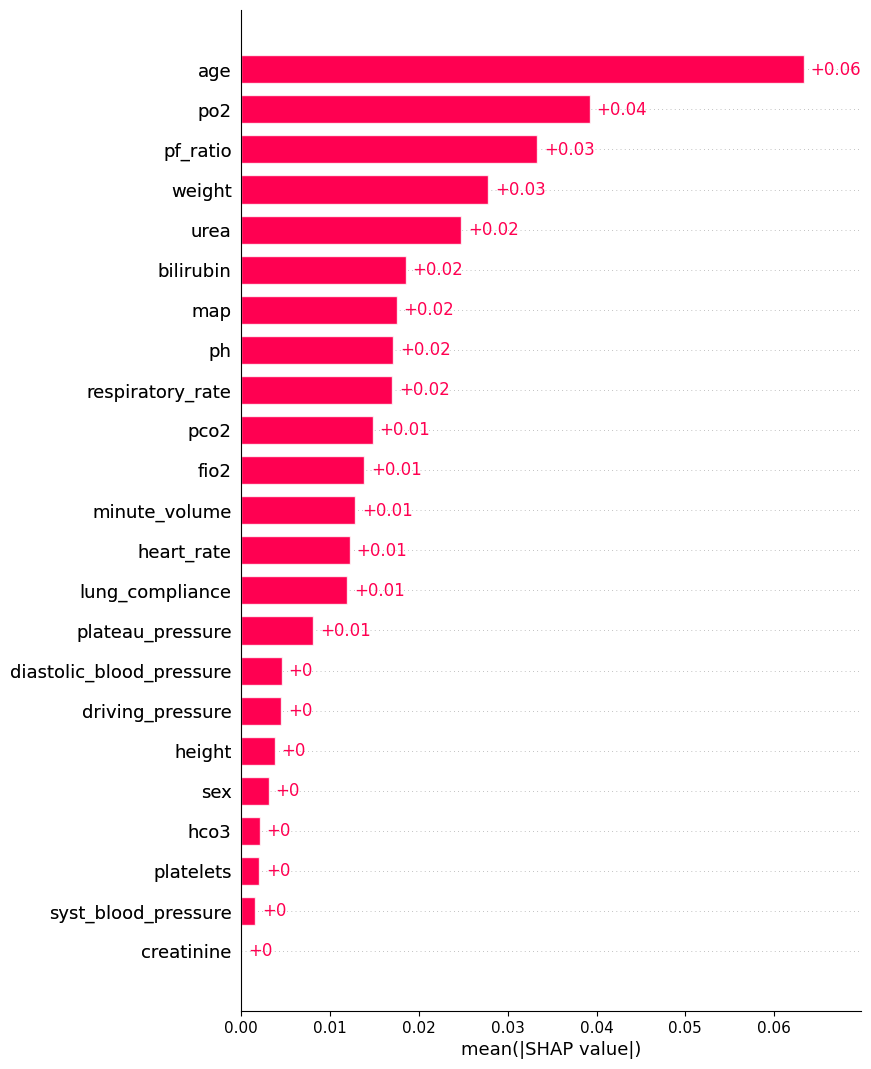

In [13]:
lin_reg_out = LinearRegression()
lin_reg_out.fit(full_data[columns_x], full_data["Y"])

explainer_lin_reg_out = shap.Explainer(lin_reg_out.predict, shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_out = explainer_lin_reg_out(imp_xs)
shap.plots.bar(shap_values_out, max_display=24)

In [14]:
corr = full_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,map,bilirubin,creatinine,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,W,Y
age,1.000000,0.093416,-0.188752,-0.156394,-0.017879,-0.004758,-0.076798,0.108183,-0.033681,-0.021403,-0.173319,-0.139932,-0.015259,0.048108,0.172815,-0.107805,0.023806,-0.229257,-0.199799,-0.150976,-0.170930,-0.050676,-0.220374,-0.180328,-0.153237
sex,0.093416,1.000000,-0.267783,-0.657658,0.010227,-0.019254,-0.047412,0.047840,0.117972,-0.269206,-0.118732,-0.025189,-0.103704,0.082280,-0.078977,-0.047630,-0.010020,0.050310,-0.369720,0.023881,-0.022621,-0.034416,-0.134618,-0.058778,-0.023593
weight,-0.188752,-0.267783,1.000000,0.369295,-0.117963,-0.120824,0.184868,-0.035035,0.029733,0.072530,0.070710,0.025568,0.113532,-0.013071,0.097162,0.075145,0.139403,-0.025226,0.294058,0.227383,0.066870,0.098274,0.047612,0.277434,0.086608
height,-0.156394,-0.657658,0.369295,1.000000,-0.002599,0.015732,0.052714,-0.050474,-0.160821,0.296002,0.103358,0.011025,0.099328,-0.066156,0.054349,0.034685,0.006219,-0.020176,0.379495,-0.058103,0.018742,0.047417,0.115122,0.052722,0.040281
pf_ratio,-0.017879,0.010227,-0.117963,-0.002599,1.000000,0.680872,-0.188837,0.100298,-0.060492,0.028111,0.033474,0.007269,-0.001422,-0.011462,-0.045165,-0.473850,-0.076561,-0.088748,-0.193018,-0.312307,-0.250454,0.022607,0.034204,-0.170715,0.014830
po2,-0.004758,-0.019254,-0.120824,0.015732,0.680872,1.000000,-0.158383,0.028744,-0.011249,0.038590,0.001620,0.013669,-0.021597,-0.067075,-0.112997,-0.128595,-0.075901,-0.052315,-0.115394,-0.215695,-0.250634,0.000080,0.002453,-0.141741,0.065382
pco2,-0.076798,-0.047412,0.184868,0.052714,-0.188837,-0.158383,1.000000,-0.262463,0.055279,-0.071870,-0.012332,-0.096530,-0.100177,0.084823,-0.042506,0.134440,0.605752,0.017338,-0.062826,0.253610,0.049409,0.011468,-0.019600,0.150972,0.056848
ph,0.108183,0.047840,-0.035035,-0.050474,0.100298,0.028744,-0.262463,1.000000,-0.041966,0.037444,0.169868,-0.050576,-0.198820,0.070153,-0.149054,-0.245121,0.510367,-0.241628,-0.291982,-0.231197,-0.289178,0.211766,0.123686,-0.134601,0.060436
driving_pressure,-0.033681,0.117972,0.029733,-0.160821,-0.060492,-0.011249,0.055279,-0.041966,1.000000,-0.654534,-0.077296,0.019261,0.045198,-0.002240,0.041626,0.115232,0.032662,0.082977,-0.023060,0.644707,0.073193,-0.035039,-0.083546,0.035393,-0.026344
lung_compliance,-0.021403,-0.269206,0.072530,0.296002,0.028111,0.038590,-0.071870,0.037444,-0.654534,1.000000,0.067917,-0.008044,-0.014905,-0.014572,-0.019000,-0.037444,-0.029581,-0.047421,0.209374,-0.409988,-0.097921,0.042084,0.078559,-0.019511,0.050457


In [15]:
columns_x

Index(['age', 'sex', 'weight', 'height', 'pf_ratio', 'po2', 'pco2', 'ph',
       'driving_pressure', 'lung_compliance', 'map', 'bilirubin', 'creatinine',
       'platelets', 'urea', 'fio2', 'hco3', 'heart_rate', 'minute_volume',
       'plateau_pressure', 'respiratory_rate', 'syst_blood_pressure',
       'diastolic_blood_pressure'],
      dtype='object')

PermutationExplainer explainer: 3942it [01:06, 53.81it/s]                          


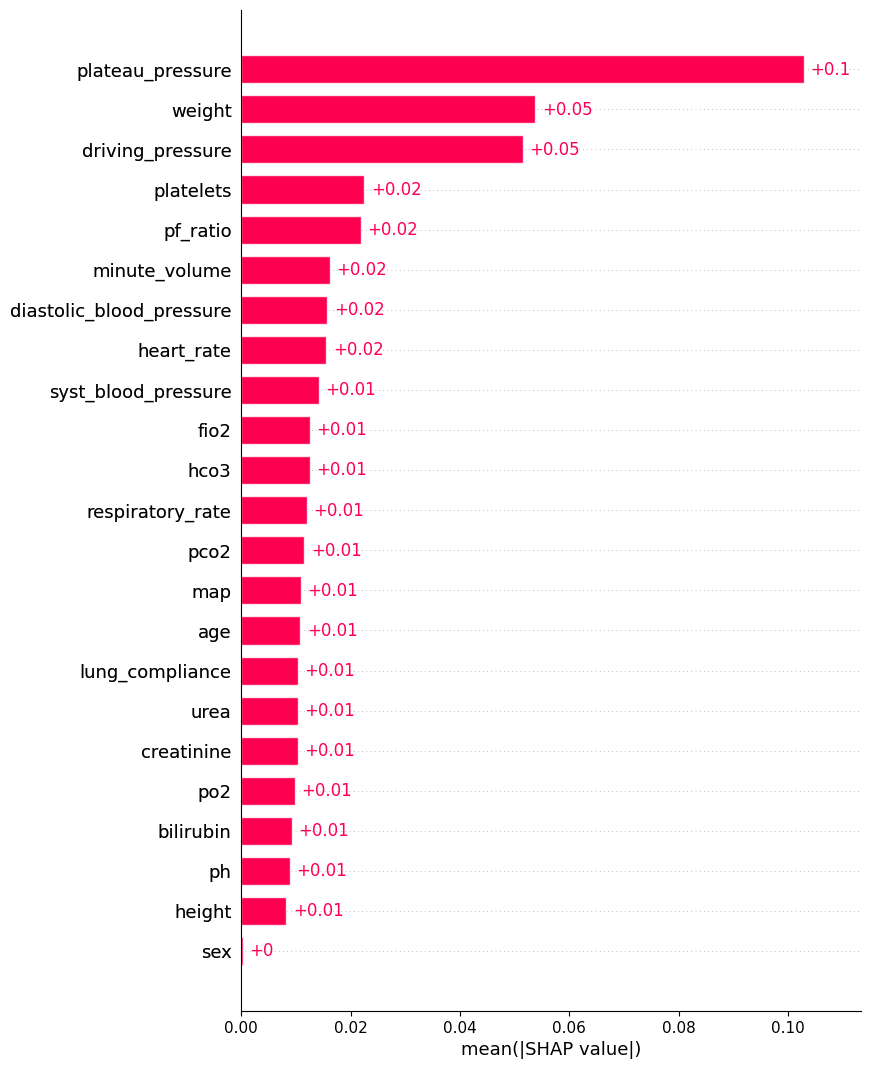

In [4]:
tree_treat = DecisionTreeRegressor()
tree_treat.fit(full_data[columns_x], full_data["W"])

explainer_tree_treat = shap.Explainer(tree_treat.predict, shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_tree_treat = explainer_tree_treat(imp_xs)
shap.plots.bar(shap_values_tree_treat, max_display=24)

PermutationExplainer explainer: 3942it [01:04, 51.39it/s]                          


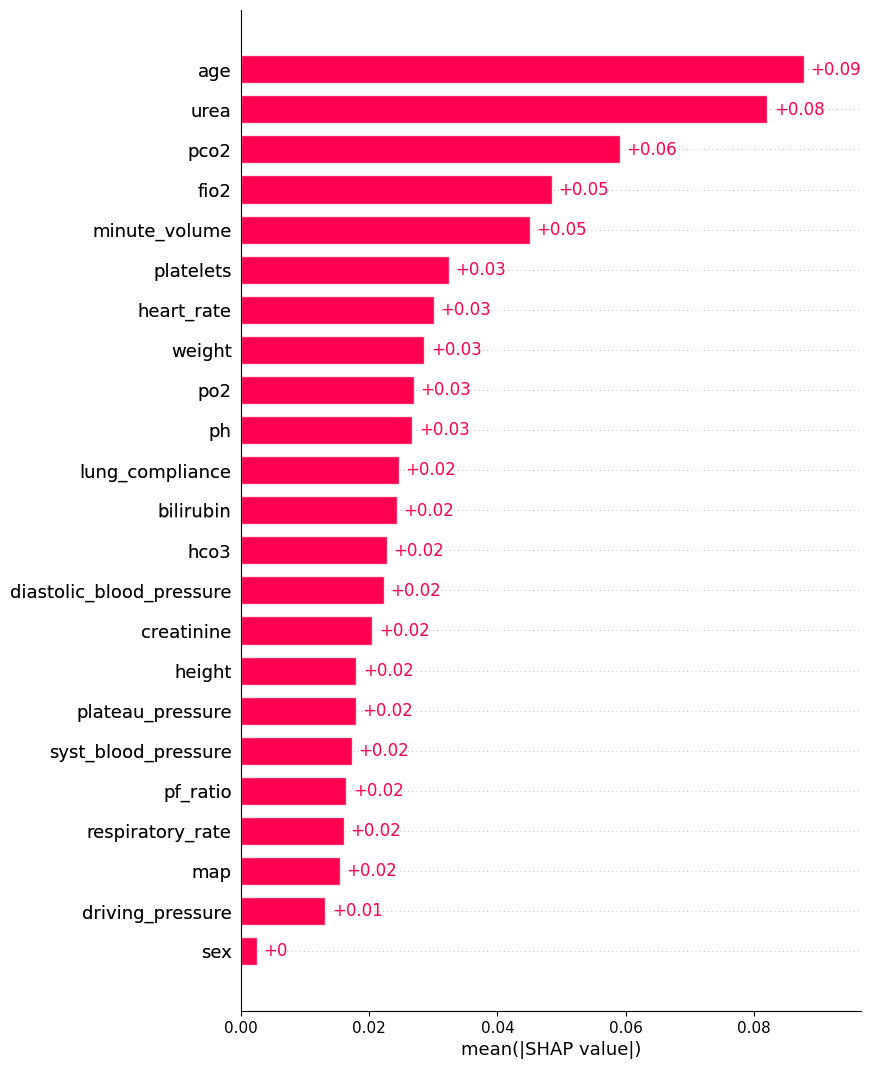

In [5]:
tree_out = DecisionTreeRegressor()
tree_out.fit(full_data[columns_x], full_data["Y"])

explainer_tree_out = shap.Explainer(tree_out.predict, shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_tree_out = explainer_tree_out(imp_xs)
shap.plots.bar(shap_values_tree_out, max_display=24)